<a href="https://colab.research.google.com/github/tiwarianup/RTM_Price_Forecast/blob/main/LD_Price_Forecast_Bagging_Boosting_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RTM IEX Price Forecasting using Bagging & Boosting Ensembles

### **Introduction**

**Problem Statement**: In recent years rapid urbanisation and aggresive electrification programs has resulted in an increase in all India energy (electric power) demand. If we observe the past trends in the data published by the Central Electricity Authority (CEA) of India, it is evident that the energy demand will continue to grow in years to come. 

On a macro level, it should not be surprising for a rapidly developing nation like India. But, when we look at the micro level which is the day to day operations of the power system, we can find many potential challanges which call for attention to improve the overall performance and efficiency of the power systems. Predicting Real Time Market (RTM) Prices accurately is one such challange for a power utility. It is of utmost importance for the nation, that power supply is never interupted and thus every power utility thrives to meet the energy demand of thier consumers. 

The challange lies in the fact that the increment or decrement of energy demand is a real time process very similar to the price movement on the stock exchanges. This fluctuation in energy demand is to be anticipated and planned in advanced for smooth power system operations. We would not go deep into the actual functioning of these systems, but it is good to know that to fulfill this real time anticipated increment or decrement in demand, a power utility may wish to buy or sell power on the Indian Energy Exchange Platform. If the power demand of the utilitys' consumers are not fulfilled, they may have to face unplaned outages resulting in customer dissatisfaction.

**Objective of this Exercise**: To analyze and model publically available data using RandomForest (Bagging)  and XGBoost (Boosting) machine learning algorithms to predict Real Time Market (RTM) Prices on Indian Energy Exchange (IEX).

**Methodology Followed**: The methodolody followed for this exercise can be summarized as follows:
1. Collecting Real Time Market prices and bids data from IEX website (Not Included)
2. Collecting All India Electricity Load (Demand) from Vidyut Pravah website (Not Included)
3. Compiling the data into a single CSV file for analysis (Not Included)
4. Importing, Inspecting and Cleaning the data
5. Visual Inspection of Data (EDA)
6. Hyperparameter Tuning and Cross Validation in RandomForest and XGBoost 
7. Predicting Prices using Best Estimators
8. Visualizing and exporting the final results

Traditionally, Time series data is modelled using statistical approaches such as Exponential Smoothening, ARIMA or SARIMAX models etc. An important peculiarity of time series data is autocorrelation, i.e. the dependency of current value on the past values. Further, a time series data is timestamped which means that there is a chronological order maintained in the data that cannot be directly recognized by machine learning models. Thus, we will use a technique called reduction which is a process to transforming the available features to account for the time dependency in the data. 

The following notebook is divided into 3 sections as following:
1. Visual Inspection of data (EDA) & Feature Engineering
2. Implementing RandomForest for Price Predictions
3. Implementing XGBoost for Price Predictions

So, let us begin the modelling exercise.

### **Section 1: Visual Inspection of Data (EDA) & Feature Engineering** 

In this section, we will work on the compiled data for analysis and modelling. We will start by importing and cleaning the data. Then, we will do some visual inspection of data by looking at correlation plots and heatmaps to derive and choose the independent variables (features) required for modelling the data. 

> Importing and Inspecting data

In [205]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [206]:
# importing required python modules
import datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost

Now, that we have imported the required modules, let us import the data using pandas module.

In [207]:
# importing required datasets
price_data = pd.read_csv('./Documents/PriceForecasting/v1/price_data.csv')

In [208]:
# inspecting price dataframe
price_data.head()

,Date,TimeblockId,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand
0,01-10-2020,1,2624.91,2089.45,949.1,3145.7,8860.0,12455.1,150321
1,01-10-2020,2,2609.88,2245.41,929.5,3122.7,8732.3,12317.0,149035
2,01-10-2020,3,2674.59,2245.89,963.4,2789,8718.6,12182.7,148483
3,01-10-2020,4,2609.42,2245.91,963.4,2818.4,8485.7,12298.9,146938
4,01-10-2020,5,2698.07,2199.82,991.8,2907.7,8728.7,12276.0,145493


We can observe that the first two columns are timestamp information related to the corresponding values in the dataframe. Each day is divided into 96 timeblocks i.e. every hour has four 15 minute time blocks. Utilities are required to place buy or sell bids for these 15 minute timeblocks. Again without going into the details of the market, we will focus on analysing and  the modelling the time series in this exercise.

In [209]:
# checking shapes of both dataframes
price_data.shape

(10656, 9)

In [210]:
# checking price data column types
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              10656 non-null  object 
 1   TimeblockId       10656 non-null  int64  
 2   DAM_Price         10656 non-null  float64
 3   RTM_Price         10656 non-null  object 
 4   RTM_Purchase_Bid  10656 non-null  object 
 5   RTM_Selling_Bid   10656 non-null  object 
 6   DAM_Purchase_Bid  10656 non-null  float64
 7   DAM_Selling_Bid   10656 non-null  float64
 8   Demand            10656 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 749.4+ KB


We can observe that the compiled price data contains 10656 rows and 9 attributes. Further, we can see that there are no null values and but few columns are not stored in the right format. We will deal with these attributes going further and apply suitable transformations on these attributes.

> **Data Cleaning**

Now, we need to convert all the values into numeric types as even though it looks like there are no null values in the dataset, it might be the case that some values are non-numeric thus, let us do that first.

In [211]:
# converting object dtypes to numeric dtype
price_data['RTM_Price'] = pd.to_numeric(price_data['RTM_Price'], errors='coerce')
price_data['DAM_Price'] = pd.to_numeric(price_data['DAM_Price'], errors='coerce')
price_data['RTM_Purchase_Bid'] = pd.to_numeric(price_data['RTM_Purchase_Bid'], errors='coerce')
price_data['RTM_Selling_Bid'] = pd.to_numeric(price_data['RTM_Selling_Bid'], errors='coerce')
price_data['DAM_Purchase_Bid'] = pd.to_numeric(price_data['DAM_Purchase_Bid'], errors='coerce')
price_data['DAM_Selling_Bid'] = pd.to_numeric(price_data['DAM_Selling_Bid'], errors='coerce')
price_data['Demand'] = pd.to_numeric(price_data['Demand'], errors='coerce')

> **Adding Weekday and Weekend effect**

Electricity power demand and consequently the prices are generally seasonal in nature. Seasonality means cyclicity of a pattern occuring in data over a short range of time. This occurs due to cyclicity in consumer demand patterns. On weekdays the demand may be more as compared to weekends and this needs to be accounted while modelling the time series data. Thus, we will derive a feature (independent variable) to account for the day of week and we will use this feature later in machine learning models.

In [212]:
# creating a column to track day of week and HolidayIds
price_data['Date'] = pd.to_datetime(price_data.Date)
price_data['Day_of_week'] = price_data['Date'].dt.dayofweek

# create a function to check if the day of week is a weekend
def is_weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

# apply is_weekend function to assign a holidayId (1/0 for Weekend/Weekday)
price_data['HolidayId'] = price_data['Day_of_week'].apply(is_weekend)
price_data = price_data.drop(columns=['Day_of_week'])
price_data.head()

,Date,TimeblockId,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand,HolidayId
0,2020-01-10,1,2624.91,2089.45,949.1,3145.7,8860.0,12455.1,150321,0
1,2020-01-10,2,2609.88,2245.41,929.5,3122.7,8732.3,12317.0,149035,0
2,2020-01-10,3,2674.59,2245.89,963.4,2789.0,8718.6,12182.7,148483,0
3,2020-01-10,4,2609.42,2245.91,963.4,2818.4,8485.7,12298.9,146938,0
4,2020-01-10,5,2698.07,2199.82,991.8,2907.7,8728.7,12276.0,145493,0


Now, we have added a feature to account for the day of week affecting the price values.

In [213]:
# check the value counts of Holiday IDs
price_data.HolidayId.value_counts()

0    7680
1    2976
Name: HolidayId, dtype: int64

Now, we can finally check the no of missing values we have in the dataset.

In [214]:
# check for missing values in price dataset
price_data.isna().sum()

Date                 0
TimeblockId          0
DAM_Price            0
RTM_Price           12
RTM_Purchase_Bid    12
RTM_Selling_Bid     12
DAM_Purchase_Bid     0
DAM_Selling_Bid      0
Demand               0
HolidayId            0
dtype: int64

Thus, this confirms that there were infact a few non-numeric values that were converted to null values while numerical conversion. We will use frontfilling or backfilling method to fill this data. However, we can use advanced interpolation techniques to fill this data as well.

In [215]:
# filling the value from previous timeblock for all NaN or NA
price_data = price_data.ffill(axis = 0)
price_data.isna().sum()

Date                0
TimeblockId         0
DAM_Price           0
RTM_Price           0
RTM_Purchase_Bid    0
RTM_Selling_Bid     0
DAM_Purchase_Bid    0
DAM_Selling_Bid     0
Demand              0
HolidayId           0
dtype: int64

> **Adding Public Holidays effect**

On account of public holidays, since many industries are shut, an impact of overall electricity load is seen which in turn impacts the prices on exchange. Thus, it will be great to add the effect of these special days. In your own respective regions, this day can be a public holiday or election day etc.

In [216]:
# Assign special days as a value of 2
price_data.loc[price_data.Date == datetime.datetime(2020,10,2,0,0,0), 'HolidayId'] = 2 #Gandhi Jayanti
price_data.loc[price_data.Date == datetime.datetime(2020,10,25,0,0,0), 'HolidayId'] = 2 #Dusshera
price_data.loc[price_data.Date == datetime.datetime(2020,10,30,0,0,0), 'HolidayId'] = 2 #Good Friday
price_data.loc[price_data.Date == datetime.datetime(2020,11,14,0,0,0), 'HolidayId'] = 2 #Diwali
price_data.loc[price_data.Date == datetime.datetime(2020,12,25,0,0,0), 'HolidayId'] = 2 #Christmas
price_data.loc[price_data.Date == datetime.datetime(2020,12,31,0,0,0), 'HolidayId'] = 2 #New Year

Here, for demonstration purposes, we have only considered holidays that lie in the timestamp range of our dataset. However, this data can also come from a secondary source and can be integrated into the pipeline.

In [217]:
price_data.HolidayId.value_counts()

0    7392
1    2784
2     480
Name: HolidayId, dtype: int64

Now that we have accounted for the effect of weekdays, weekends and special days on the price movements in our data, we are ready to make transformations to prepare the data required for modelling. As discussed earlier, we will use a technique called reduction to account for time dependency and autocorrelation in the price values. But, before that lets us visualize the data to get an intuition of the required features that can be fed into our machine learning models.

> **Exploratory Data Analysis**

In this sections, we will look at the Auto Correlation Function (ACF) plots to check for time dependency as well heatmap to understand the correlations between dependent and independent variables.

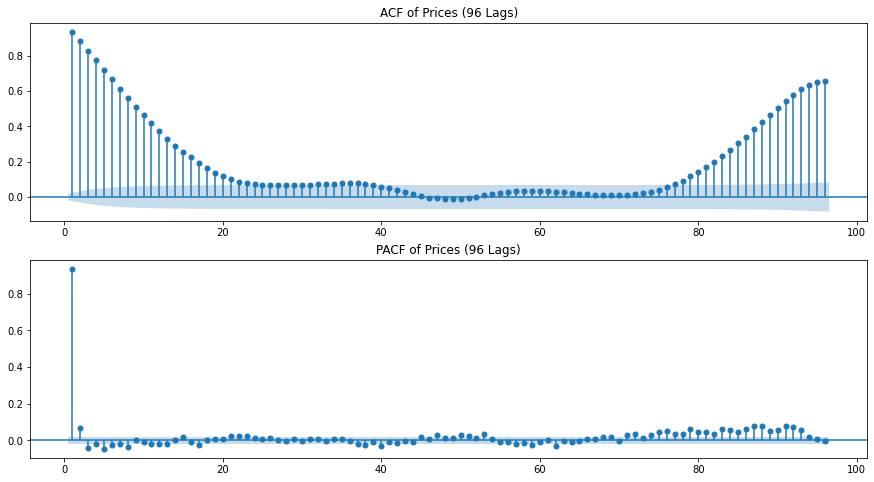

In [218]:
# plotting the autocorrelation and partial autocorrelation plots for prices
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(price_data.RTM_Price, lags=96, ax=ax[0], zero=False, title='ACF of Prices (96 Lags)')
fig = sm.graphics.tsa.plot_pacf(price_data.RTM_Price, lags=96, ax=ax[1], zero=False, title='PACF of Prices (96 Lags)')
plt.show()

The ACF plot suggests that the dependency of current price value on the last 20 lags (no of time periods behind the current time period) is significant. The PACF plot suggests that upto 7 lags are significant in explaining the current price value. This clearly indicates that the timeblock in which the trade executes has some dependency on the TimeBlockId, thus we need to account for this dependency.

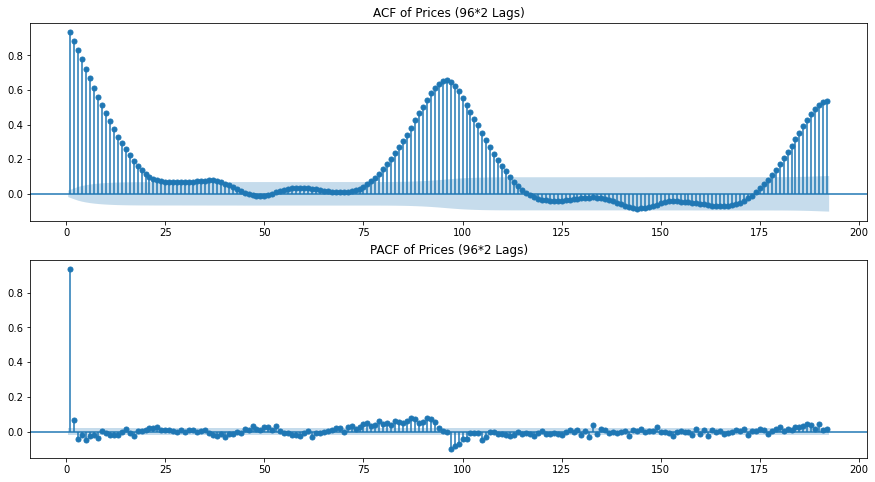

In [219]:
# plotting the autocorrelation and partial autocorrelation plots for prices
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(price_data.RTM_Price, lags=96*2, ax=ax[0], zero=False, title='ACF of Prices (96*2 Lags)')
fig = sm.graphics.tsa.plot_pacf(price_data.RTM_Price, lags=96*2, ax=ax[1], zero=False, title='PACF of Prices (96*2 Lags)')
plt.show()

The ACF plot suggests that the dependency of current price value on the lags before 96 blocks (lags) is significant. The PACF plot suggests that upto 7 lags from the previous day are significant in explaining the current price value. This clearly indicates that the timeblock in which the trade executes has some dependency on the TimeBlockId, thus we need to account for this dependency.

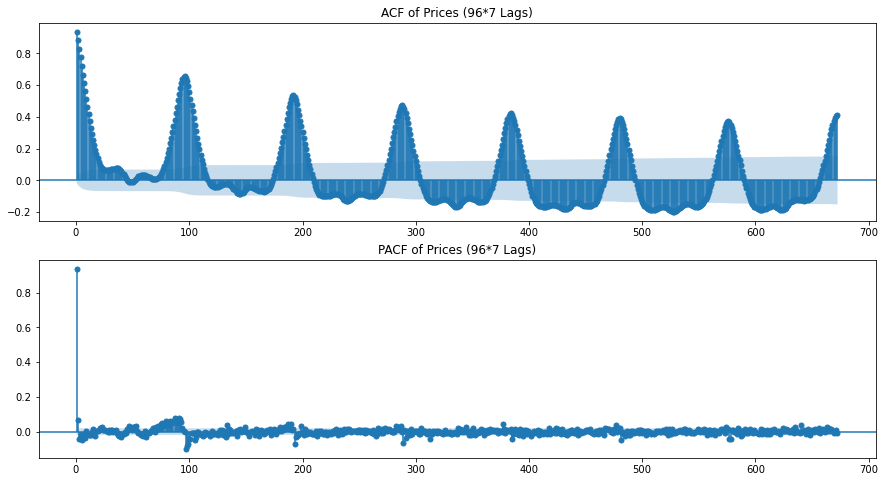

In [220]:
# plotting the autocorrelation and partial autocorrelation plots for prices
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(price_data.RTM_Price, lags=96*7, ax=ax[0], zero=False, title='ACF of Prices (96*7 Lags)')
fig = sm.graphics.tsa.plot_pacf(price_data.RTM_Price, lags=96*7, ax=ax[1], zero=False, title='PACF of Prices (96*7 Lags)')
plt.show()

Again, we checked if there is an evidence of correlation between the price values one week back. The ACF and PACF plots displayed above suggest that timeperiods 7 days back are significant in explaining the current values suggesting presence of a weekly seasonality that should also be accounted for.

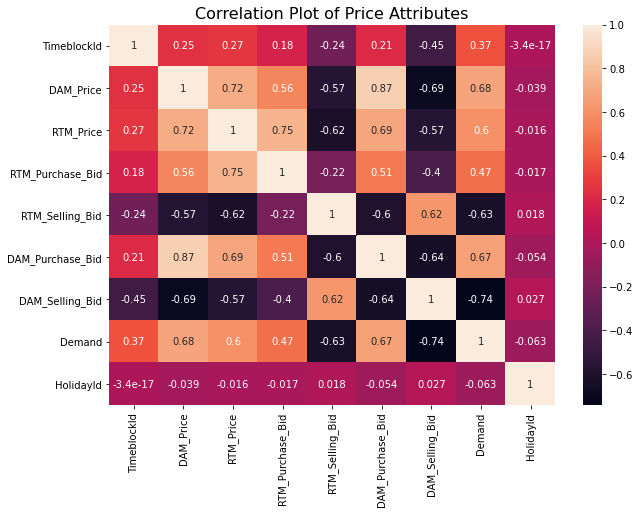

In [221]:
# checking the correlation between the variables
# by plotting the heatmap of the correlation matrix
plt.figure(figsize=(10,7))
sns.heatmap(price_data.corr(), annot=True)
plt.title('Correlation Plot of Price Attributes', size=16)
plt.show()

We can see that the dependent variable i.e. `RTM_Price` is very well correlated to the features present in the dataset. Though, we can observe some multicollinearity between the independent variables (features), our choice of modelling algorithms (i.e. the inherent design of the algorithm such as RandomForest of XGboost) are able to handle presence of multicollinearity among the features. This is because both of these algorithms use Ensembles of Decision Trees built on subsets of these features thus reducing the chance of usage of multicollinear features for estimations.

On the basis of these findings, we will do data preparation for modelling by applying required transformations to account for timeblock dependence and weekly seasonality.

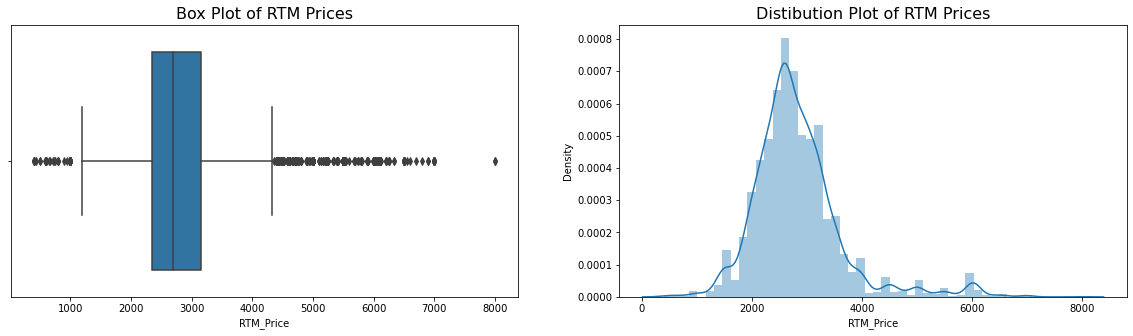

In [222]:
# check for the box plot and distribution of price data in the dataset
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Box Plot of RTM Prices', size=16)
sns.boxplot(price_data.RTM_Price)
plt.subplot(1,2,2)
plt.title('Distibution Plot of RTM Prices', size=16)
sns.distplot(price_data.RTM_Price)
plt.show()

The boxplots shows the presence of few extreme values in the dataset. We may think of removing or capping these values but we will let it remain as it is as it is representative of real time situations and thus we should be able to model such instances as well.

In the distribution plot we can see that the prices approximately follows a normal distribution, thus we can apply our machine learning algorithms on price as the target variable without any transformations.

> **Data Preparation and Feature Engineering**

Now, we will do feature engineering and create a new dataset holding only the variables required for modelling.

In [223]:
# create two dataframe to hold values
# two dataframes are created to hold current day and last week same day values
# finally we will use df1 dataframe to create the train-test split thus df2 is a temporary df
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [224]:
# we start at 8th october to backtrack and create variables to
# account for previous week and previous day dependencies in the data
oct8index = 672 # 96*7
df1['TimeblockId'] = price_data['TimeblockId'][oct8index:]
df1['HolidayId'] = price_data['HolidayId'][oct8index:]
df1['DAM_Price'] = price_data['DAM_Price'][oct8index:]
df1['DAM_Purchase_Bid'] = price_data['DAM_Purchase_Bid'][oct8index:]
df1['DAM_Selling_Bid'] = price_data['DAM_Selling_Bid'][oct8index:]
df1['RTM_Price_SD'] = price_data['RTM_Price'][oct8index:]

df1.reset_index(inplace = True)
df1 = df1.drop(['index'], axis = 1)

last_wkday_index = -672

# taking data from same day last week 
# same day is 8th Oct so starting same day last week is 1st Oct
df1['RTM_Price_SDLW'] = price_data['RTM_Price'][:last_wkday_index]
df1['RTM_Purchase_Bid_SDLW'] = price_data['RTM_Purchase_Bid'][:last_wkday_index]
df1['RTM_Selling_Bid_SDLW'] = price_data['RTM_Selling_Bid'][:last_wkday_index]

# taking data from same day last week 
# same day is 8th Oct so starting same day last week is 1st Oct

oct7_index = 576 # 96*6 blocks
df2['RTM_Price_PD'] = price_data['RTM_Price'][oct7_index:-96]
df2['RTM_Purchase_Bid_PD'] = price_data['RTM_Purchase_Bid'][oct7_index:-96]
df2['RTM_Selling_Bid_PD'] = price_data['RTM_Selling_Bid'][oct7_index:-96]
df2.reset_index(inplace = True)
df2.drop('index', axis=1, inplace=True)
df2.head()

,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD
0,3673.80,2115.6,2284.8
1,3673.08,2062.1,2337.6
2,3199.19,1715.5,2371.5
3,3199.29,1716.8,2363.8
4,2999.96,1459.3,2156.3


In [225]:
# check shapes of both dataframes
df1.shape, df2.shape

((9984, 9), (9984, 3))

In [226]:
# merging values from both dataframes
df1['RTM_Price_PD'] = df2['RTM_Price_PD']
df1['RTM_Purchase_Bid_PD'] = df2['RTM_Purchase_Bid_PD']
df1['RTM_Selling_Bid_PD'] = df2['RTM_Selling_Bid_PD']

df1 = df1[['TimeblockId','HolidayId','DAM_Price','DAM_Purchase_Bid','DAM_Selling_Bid','RTM_Price_PD',
           'RTM_Purchase_Bid_PD','RTM_Selling_Bid_PD','RTM_Price_SDLW','RTM_Purchase_Bid_SDLW', \
           'RTM_Selling_Bid_SDLW', 'RTM_Price_SD']]

df1.head()

,TimeblockId,HolidayId,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD
0,1,0,2849.39,10274.1,10312.4,3673.80,2115.6,2284.8,2089.45,949.1,3145.7,3921.56
1,2,0,2804.69,10187.2,10410.3,3673.08,2062.1,2337.6,2245.41,929.5,3122.7,3921.12
2,3,0,2802.65,10142.6,10411.2,3199.19,1715.5,2371.5,2245.89,963.4,2789.0,3214.28
3,4,0,2749.39,9716.9,10466.8,3199.29,1716.8,2363.8,2245.91,963.4,2818.4,3199.59
4,5,0,2799.37,9666.8,10427.3,2999.96,1459.3,2156.3,2199.82,991.8,2907.7,3119.50


> **Demand Data Transformations to take previous day and previous week effect**

Next, we will apply some transformation on the demand data to extact the previous day and previous week demand into account.

In [227]:
## taking data from same day last week 
# same day is 8th Oct so starting same day last week is 1st Oct
# previous day is 7th Oct
df2= pd.DataFrame()
df2['Demand_PD'] = price_data['Demand'][576:-96]
df2.reset_index(inplace = True)
df2 = df2.drop(['index'], axis = 1)

df1['Demand_PD'] = df2['Demand_PD']
df2= pd.DataFrame()
df2['Demand_SDLW'] = price_data['Demand'][192:-672]
df2.reset_index(inplace = True)
df2 = df2.drop(['index'], axis = 1)

df1['Demand_SDLW'] = df2['Demand_SDLW']
df1.head()

,TimeblockId,HolidayId,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD,Demand_PD,Demand_SDLW
0,1,0,2849.39,10274.1,10312.4,3673.80,2115.6,2284.8,2089.45,949.1,3145.7,3921.56,145315,148652.0
1,2,0,2804.69,10187.2,10410.3,3673.08,2062.1,2337.6,2245.41,929.5,3122.7,3921.12,143759,147277.0
2,3,0,2802.65,10142.6,10411.2,3199.19,1715.5,2371.5,2245.89,963.4,2789.0,3214.28,143365,146777.0
3,4,0,2749.39,9716.9,10466.8,3199.29,1716.8,2363.8,2245.91,963.4,2818.4,3199.59,141513,145130.0
4,5,0,2799.37,9666.8,10427.3,2999.96,1459.3,2156.3,2199.82,991.8,2907.7,3119.50,139912,143633.0


In [228]:
# create dummy variables for HolidayIds and Time Blocks
df1 = pd.get_dummies(df1, columns = ['HolidayId'] )
df1 = pd.get_dummies(df1, columns = ['TimeblockId'] )
df1 = df1[['TimeblockId_1','TimeblockId_2','TimeblockId_3','TimeblockId_4','TimeblockId_5','TimeblockId_6','TimeblockId_7',
           'TimeblockId_8','TimeblockId_9','TimeblockId_10','TimeblockId_11','TimeblockId_12','TimeblockId_13','TimeblockId_14',
           'TimeblockId_15','TimeblockId_16','TimeblockId_17','TimeblockId_18','TimeblockId_19','TimeblockId_20','TimeblockId_21',
           'TimeblockId_22','TimeblockId_23','TimeblockId_24','TimeblockId_25','TimeblockId_26','TimeblockId_27','TimeblockId_28',
           'TimeblockId_29','TimeblockId_30','TimeblockId_31','TimeblockId_32','TimeblockId_33','TimeblockId_34','TimeblockId_35',
           'TimeblockId_36','TimeblockId_37','TimeblockId_38','TimeblockId_39','TimeblockId_40','TimeblockId_41','TimeblockId_42',
           'TimeblockId_43','TimeblockId_44','TimeblockId_45','TimeblockId_46','TimeblockId_47','TimeblockId_48','TimeblockId_49',
           'TimeblockId_50','TimeblockId_51','TimeblockId_52','TimeblockId_53','TimeblockId_54','TimeblockId_55','TimeblockId_56',
           'TimeblockId_57','TimeblockId_58','TimeblockId_59','TimeblockId_60','TimeblockId_61','TimeblockId_62','TimeblockId_63',
           'TimeblockId_64','TimeblockId_65','TimeblockId_66','TimeblockId_67','TimeblockId_68','TimeblockId_69','TimeblockId_70',
           'TimeblockId_71','TimeblockId_72','TimeblockId_73','TimeblockId_74','TimeblockId_75','TimeblockId_76','TimeblockId_77',
           'TimeblockId_78','TimeblockId_79','TimeblockId_80','TimeblockId_81','TimeblockId_82','TimeblockId_83','TimeblockId_84',
           'TimeblockId_85','TimeblockId_86','TimeblockId_87','TimeblockId_88','TimeblockId_89','TimeblockId_90','TimeblockId_91',
           'TimeblockId_92','TimeblockId_93','TimeblockId_94','TimeblockId_95','TimeblockId_96','HolidayId_0','HolidayId_1',
           'HolidayId_2','DAM_Price', 'DAM_Purchase_Bid', 'DAM_Selling_Bid', 'RTM_Price_PD', 'RTM_Purchase_Bid_PD', 
           'Demand_PD', 'RTM_Selling_Bid_PD', 'RTM_Price_SDLW', 'RTM_Purchase_Bid_SDLW', 'RTM_Selling_Bid_SDLW', 
            'RTM_Price_SD']]
df1.head()

,TimeblockId_1,TimeblockId_2,TimeblockId_3,TimeblockId_4,TimeblockId_5,TimeblockId_6,TimeblockId_7,TimeblockId_8,TimeblockId_9,TimeblockId_10,...,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,Demand_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD
0,1,0,0,0,0,0,0,0,0,0,...,10274.1,10312.4,3673.80,2115.6,145315,2284.8,2089.45,949.1,3145.7,3921.56
1,0,1,0,0,0,0,0,0,0,0,...,10187.2,10410.3,3673.08,2062.1,143759,2337.6,2245.41,929.5,3122.7,3921.12
2,0,0,1,0,0,0,0,0,0,0,...,10142.6,10411.2,3199.19,1715.5,143365,2371.5,2245.89,963.4,2789.0,3214.28
3,0,0,0,1,0,0,0,0,0,0,...,9716.9,10466.8,3199.29,1716.8,141513,2363.8,2245.91,963.4,2818.4,3199.59
4,0,0,0,0,1,0,0,0,0,0,...,9666.8,10427.3,2999.96,1459.3,139912,2156.3,2199.82,991.8,2907.7,3119.50


Thus, now we have the final dataframe `df1` containing all the independent variables and the dependent variable on which we can apply the machine learning models. The final dataframe contains 9984 observations with 109 feature attributes and 1 target variable.

> **Creating Training and Testing Datasets**

Now, we will create train and test datasets. Since, timeseries data analysis requires us to maintain the chronological order of data, we would not be able to use shuffled `train_test_split` function present in `sklearn`. Thus, we will manually create a train test split based on no of training days and no of prediction blocks. Normally in the Real Time Electricity Market, bids are submitted for two timeblocks and thus, we need to with as much accuracy as possible, predict the two timeblocks ahead forecasts. 

**Note:** Another peculiarity that arises with time series data is the train, validation, test data splits may not follow the pattern available in either of the sets specially when the volatility is high in the dataset and volatility in prices is often encountered. Thus, we would like to make our training set as large as possible to contain as much information as possible in the dataset. This can lead to overfitting but after several iterations, here we have choosen to train the model on all the data except for the last 96 blocks which we choose as the test set. 

You can play around and change these user inputs to train the model on the shorter or longer time period and use more than 96 time blocks for the validation/test sets.

In [229]:
# creating dependent and independent variable and storing as numpy arrays
X = df1.iloc[:,:-1].values
y = df1.iloc[:,-1].values

In [230]:
# checking shapes of dependent and independent variables arrays
X.shape, y.shape

((9984, 109), (9984,))

In [231]:
# user inputs for no of training days and no of prediction blocks (test set)
n_train_days = 92 # int(input("No. of Training Days: "))
n_pred_block = 96 # int(input("No. of Time Blocks to Predict: "))

In [232]:
# creating train test split
# predicting the RTM Price 
# 1 signifies value of latest day and as n value increases we move backward from current day

n = 1
X_train,y_train  = X[-(n_train_days + n)*96:-96*n,:] , y[-(n_train_days + n)*96:-96*n]
if n > 1:
    if n_pred_block == 96:
        X_test , y_test = X[-96*n:-96*(n-1),:] , y[-96*n:-96*(n-1)]
    else:
        X_test , y_test = X[-96*n:-96*n + n_pred_block, :] , y[-96*n:-96*n + n_pred_block]

if n==1:
    if n_pred_block == 96:
        X_test , y_test = X[-96*n:, :] , y[-96*n:]
    else:
        X_test , y_test = X[-96*n:-96*n + n_pred_block, :] , y[-96*n:-96*n + n_pred_block]

In [233]:
# check the shapes of train and test sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8832, 109), (8832,), (96, 109), (96,))

### **Section 2: Implementing XGBoost for Price predictions**

In this section, we will use the training data to perform Hyperparameter tuning for `XGBRegressor` and use the best estimators obtained from grid search cross validation to predict the prices.

**Hyperparameter Tuning for XGBoost using GridSearch CrossValidation**

The following parameter grid used for `GridSearchCV` is obtained after a few iterations of `RandomSearchCV` technique. We will use `neg_mean_squared_error` as the evaluation scoring criteria on the validation sets. The `best_estimator_` attribute of the gridsearch instance will give us the fit with best parameters.

In [234]:
#Hyperparameter Tuning of Xgboost Model

parameters_for_testing = {
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0.05, 0.06],
    'learning_rate': [0.06, 0.07, 0.1],
    'max_depth': [4,5,6],
    'n_estimators': [100, 110]
     }

# define the XGBoost instance
xgb_model = xgboost.XGBRegressor()

# define gridsearch instance with appropritate parameters
gs_xgb = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1,
                        verbose=1,scoring='neg_mean_squared_error')

# perform grid search to find the best fit parameters
gs_xgb.fit(X_train,y_train)

# print best gridsearch cv results
print('Best Params:', gs_xgb.best_params_)
print('Best Score:', gs_xgb.best_score_)
print('Best Estimator:', gs_xgb.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


Best Params: {'colsample_bytree': 0.5, 'gamma': 0.05, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100}
Best Score: -288694.9656970505
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=48, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


> **Make Predictions using the Best Estimator**

In [235]:
# use the best grid search estimator to predict on the test dataset
best_regr = gs_xgb.best_estimator_ 
"""xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=110, n_jobs=48, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) # obtained by gs_xgb.best_estimator_#
             """
best_regr.fit(X_train,y_train)

xgb_predictions = best_regr.predict(X_test)

> **Evaluate model accuracy**

In [236]:
# MAPE for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_rf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

def evalute_xgb(y_pred, y_test, n_pred_block):
  test_diff = np.abs(y_pred - y_test)

  #MAE for test set
  diff_day = []
  diff_sum = 0
  time = 0
  for i in test_diff:
      if time != n_pred_block-1:
          diff_sum +=i
          time +=1
      else:
          diff_sum = diff_sum/n_pred_block
          diff_day.append(diff_sum)
          diff_sum = 0
          time = 0

  mape0 = mean_absolute_percentage_error(y_test, y_pred)

  #Max error and Min Error for the test set
  max_error  = max(test_diff)
  min_error = min(test_diff)

  print('Maximum Error of the day = ',max_error)
  print('Minimum Error of the day = ',min_error)
  print('Mean Absolute Error of the day = ',diff_day)

  print('Average RTM Price = ',np.mean(y_test))
  mape1 = mean_absolute_percentage_error(y_test[:24],xgb_predictions[:24])
  mape2 = mean_absolute_percentage_error(y_test[24:48],xgb_predictions[24:48])
  mape3 = mean_absolute_percentage_error(y_test[48:72],xgb_predictions[48:72])
  mape4 = mean_absolute_percentage_error(y_test[72:],xgb_predictions[72:])
  #Error during different sections of day:
  print('MAPE during 00:00-06:00 hrs = ',mape1)
  print('MAPE during 06:00-12:00 hrs = ',mape2)
  print('MAPE during 12:00-18:00 hrs = ',mape3)
  print('MAPE during 18:00-24:00 hrs = ',mape4)

> **Model Evaluation on Test Set**

In [237]:
# evaluating XGB regressor results on the test dataset
evalute_xgb(xgb_predictions, y_test, n_pred_block)

Maximum Error of the day =  2760.33984375
Minimum Error of the day =  7.1733691406248
Mean Absolute Error of the day =  [756.5341135152185]
Average RTM Price =  3989.9464583333333
MAPE during 00:00-06:00 hrs =  11.95734952581325
MAPE during 06:00-12:00 hrs =  22.49845547564474
MAPE during 12:00-18:00 hrs =  22.06340889151566
MAPE during 18:00-24:00 hrs =  8.165047204889216


Thus, we have ~85% accuracy on test dataset. Thus, our predictions are fairly good and the model is not overfitting to the outliers and volatility in the dataset and does a good job to capture the underlying trends in the data at a daily level. 

> **Comnparison of Actual vs Predicted Prices obtained using XGBoost**

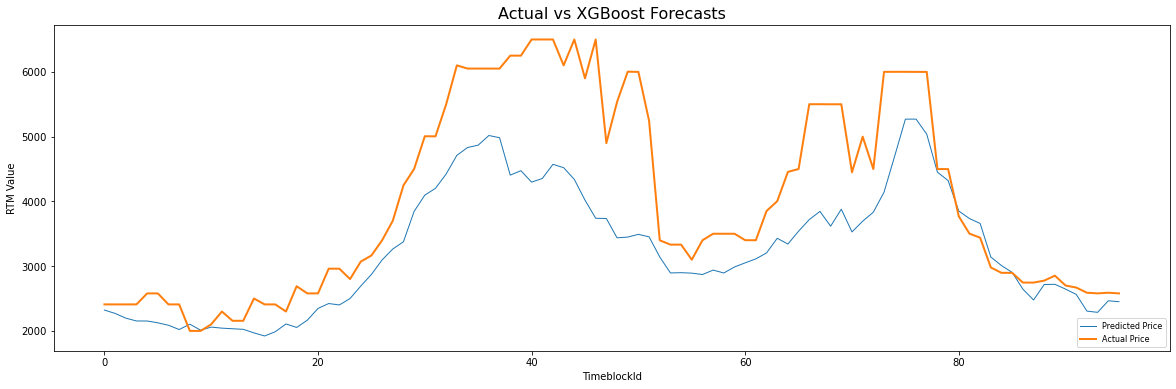

In [238]:
# evaluation performance on the test dataset
# plotting actual vs predicted data
plt.figure(figsize=(20,6))
plt.xlabel('TimeblockId', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(xgb_predictions, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.title('Actual vs XGBoost Forecasts', size=16)
plt.show()

### **Section 3: Implementing RandomForest for Price predictions**

In this section, we will use the training data to perform Hyperparameter tuning for `RandomForestRegressor` and use the best estimators obtained from grid search cross validation to predict the prices.


> **Hyperparameter Tuning for RandomForestRegressor using GridSearch CrossValidation**

The following parameter grid used for `GridSearchCV` is obtained after a few iterations of `RandomSearchCV` technique. We will use neg_mean_squared_error as the evaluation scoring criteria on the validation sets. The `best_estimator_` attribute of the gridsearch instance will give us the fit with best parameters.

In [239]:
# define the parameters to perform hyperparameter tuning

param_grid = {
    'bootstrap': [True,False],
    'max_depth': [10, 15],
    'max_features': [13, 15,18],
    'min_samples_leaf': [4,5],
    'min_samples_split': [36, 50, 60],
    'n_estimators': [700, 750, 800]
}

# create the random forest regressor instance
rf = RandomForestRegressor()

# create the gridsearch instance
gs_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          n_jobs = -1, verbose = 2, scoring='r2')

# peform grid search cross validation
gs_rf.fit(X_train,y_train)

# print the grid search results
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)
print('Best Estimator:', gs_rf.best_estimator_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  8.2min finished


Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 18, 'min_samples_leaf': 4, 'min_samples_split': 36, 'n_estimators': 700}
Best Score: 0.5488524548371542
Best Estimator: RandomForestRegressor(max_depth=10, max_features=18, min_samples_leaf=4,
                      min_samples_split=36, n_estimators=700)


The best estimator obtained using Hyperparameter tuning coupled with GridSearchCV gave us ~85% accuracy on the train dataset. Now, let us make the predictions on the test set and evaluate model performance.

In [240]:
# make predictions using best estimator and evaluate model performace on training set
best_grid = gs_rf.best_estimator_
grid_accuracy = evaluate_rf(best_grid, X_test, y_test)

Model Performance
Average Error: 711.1415 degrees.
Accuracy = 84.64%.


> **Making prediction using best RF estimator found using `GridSearchCV`**

In [241]:
# perform predictions on the test set and evaluate model performance
best_regr = best_grid
# best grid = RandomForestRegressor(max_depth=10, max_features=15, min_samples_leaf=4, 
# min_samples_split=50, n_estimators=800)

# make prediction on test set
best_regr.fit(X_train,y_train)
rf_predictions = best_regr.predict(X_test)

# evaluate model on test set
evalute_model(rf_predictions, y_test, n_pred_block)

Maximum Error of the day =  2598.4647404600973
Minimum Error of the day =  15.490902050112709
Mean Absolute Error of the day =  [707.4508663797345]
Average RTM Price =  3989.9464583333333
MAPE during 00:00-06:00 hrs =  12.912854536744248
MAPE during 06:00-12:00 hrs =  21.037841105083967
MAPE during 12:00-18:00 hrs =  17.95532627563596
MAPE during 18:00-24:00 hrs =  9.382668273659263
Full Day MAPE = 15.322172547780857


Thus, we have ~85% accuracy on test dataset as well. Thus, our predictions are fairly good and the model is not overfitting to the outliers and volatility in the dataset and does a good job to capture the underlying trends in the data at a daily level. 

> **Comparison of Actual vs Predicted Prices obtained using RanfomForest**

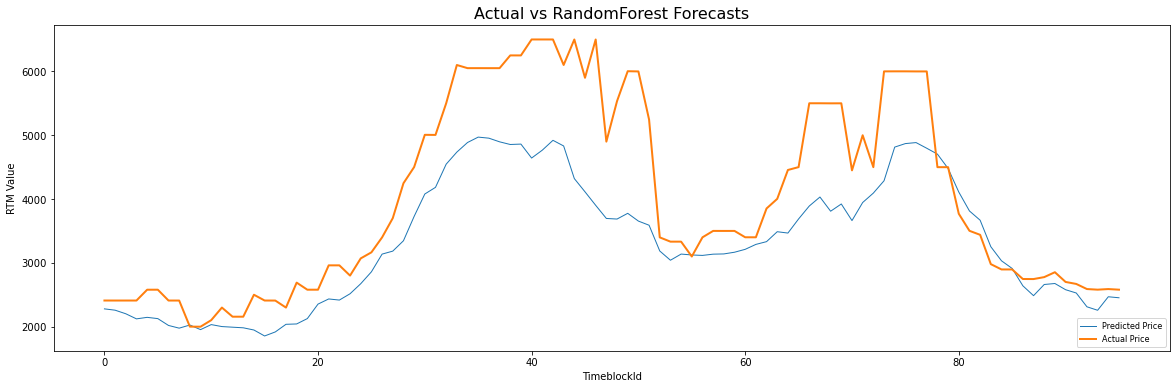

In [242]:
# comparison of actual vs predicted prices using randomforest
plt.figure(figsize=(20,6))
plt.xlabel('TimeblockId', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(rf_predictions, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.title('Actual vs RandomForest Forecasts', size=16)
plt.show()

> **Exporting the results to csv file**

In [243]:
# exporting results to csv files
rf_forecasts = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : rf_predictions,"Difference": y_test-rf_predictions})
rf_forecasts.to_csv("Forecast_RF.csv", index=False)
xgb_forecasts = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : xgb_predictions,"Difference":  y_test-xgb_predictions})
xgb_forecasts.to_csv("Forecast_XGB.csv", index=False)

**Recap:** In this exercise, we saw how we can apply XGBoost and RandomForest models on Timeseries data using a technique called reduction. We then applied data cleaning, data transformation and feature engineering to perform reduction. Then, we trained the train sets on both the ML algorithms vy performing Hyperparameter tuning and cross validation. Finally, we evaluated the performace of the best estimators on the test set. Both the algorithm gave ~85% accuracy on test sets. 

**Next Steps**: If you wish to extend this exercise, you may wish to model the generator outages, weather impacts on electricity demand, volatility analysis of prices etc. to further improve the performance of these models.